In [1]:
%pip install tensorflow

In [2]:
#Importing the libraries
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load and preprocess the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
x_train = train_images / 255.0
x_test = test_images / 255.0
y_train = to_categorical(train_labels, 10)
y_test = to_categorical(test_labels, 10)


170498071/170498071 [==============================] - 6s 0us/step


In [4]:
# Number of classes in the dataset
num_classes = np.unique(np.argmax(y_train, axis=1)).shape[0]
print(f"Number of classes: {num_classes}")

# Count of images for each class
for class_index in range(num_classes):
    class_count = np.sum(np.argmax(y_train, axis=1) == class_index)
    print(f"Number of images in class {class_index}: {class_count}")


Number of classes: 10
Number of images in class 0: 5000
Number of images in class 1: 5000
Number of images in class 2: 5000
Number of images in class 3: 5000
Number of images in class 4: 5000
Number of images in class 5: 5000
Number of images in class 6: 5000
Number of images in class 7: 5000
Number of images in class 8: 5000
Number of images in class 9: 5000


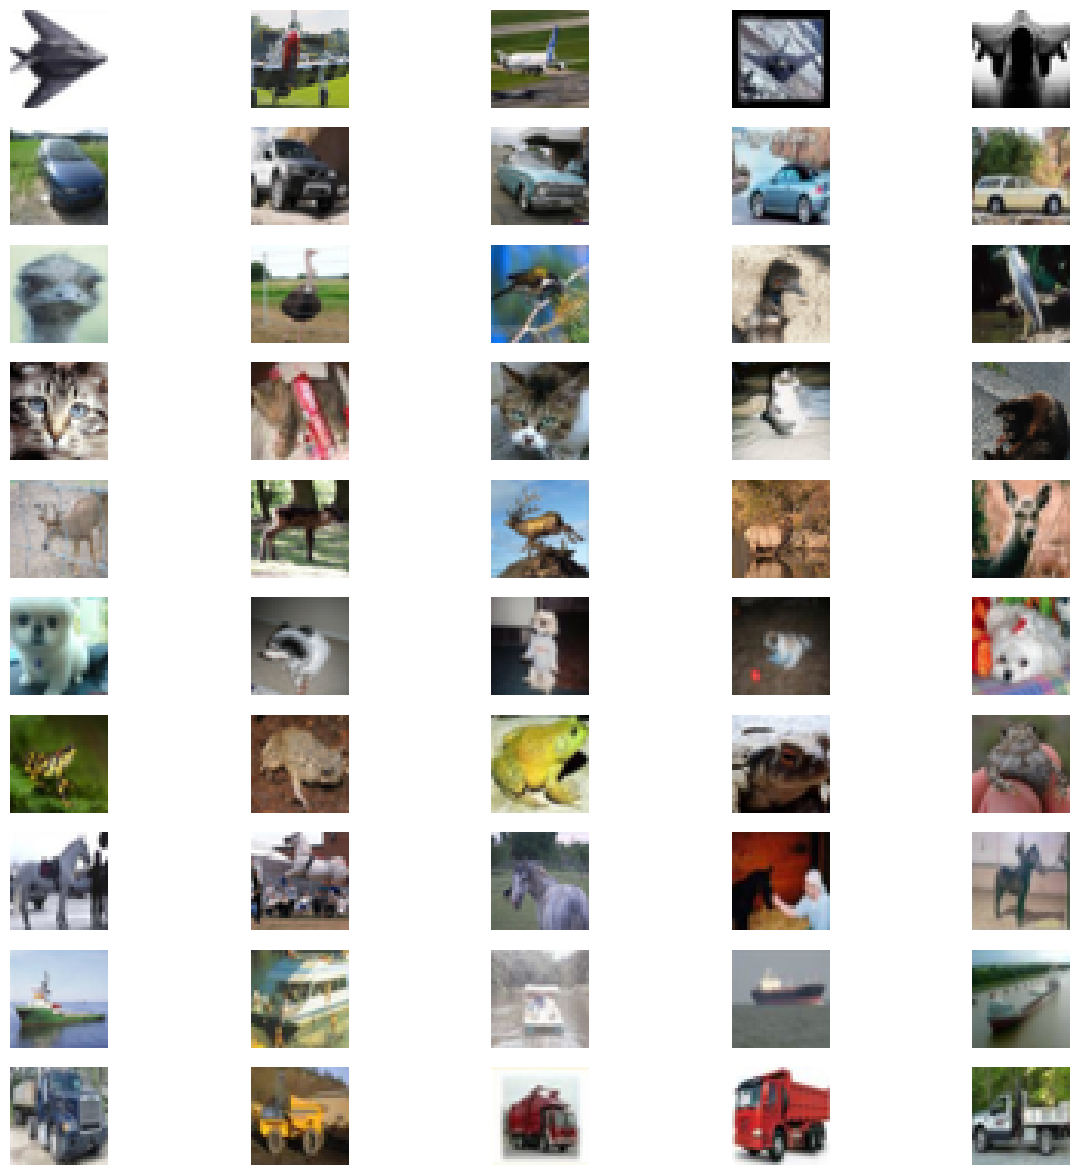

In [5]:
# Save some sample images to a PNG file
def save_variety_sample_images(images, labels, num_samples=5):
    num_classes = len(np.unique(np.argmax(labels, axis=1)))

    fig, axes = plt.subplots(num_classes, num_samples, figsize=(15, 15), dpi=100)

    for class_index in range(num_classes):
        class_indices = np.where(np.argmax(labels, axis=1) == class_index)[0]
        variety_sample_indices = np.random.choice(class_indices, num_samples, replace=False)

        for sample_index, index in enumerate(variety_sample_indices):
            axes[class_index, sample_index].imshow(images[index], interpolation='nearest')
            axes[class_index, sample_index].axis('off')

    plt.savefig('variety_sample_images.png')
    plt.show()

# Save and display variety of sample images
save_variety_sample_images(x_train, y_train)



In [6]:
# Load the ResNet50 model without the top layer (classification head)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of the custom base model
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 3s 0us/step


In [7]:
# Create a new model and add the custom base model
custom_model = Sequential()
custom_model.add(base_model)

# Add custom dense layers for the classification head
custom_model.add(Flatten())
custom_model.add(Dense(256, activation='relu'))
custom_model.add(Dense(10, activation='softmax'))

In [8]:
# Compile the custom model
custom_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the custom model
custom_model_history = custom_model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/5
1563/1563 [==============================] - 35s 17ms/step - loss: 2.0360 - accuracy: 0.2556 - val_loss: 1.9614 - val_accuracy: 0.2808
Epoch 2/5
1563/1563 [==============================] - 25s 16ms/step - loss: 1.8820 - accuracy: 0.3150 - val_loss: 1.8048 - val_accuracy: 0.3537
Epoch 3/5
1563/1563 [==============================] - 23s 14ms/step - loss: 1.8271 - accuracy: 0.3391 - val_loss: 1.8449 - val_accuracy: 0.3384
Epoch 4/5
1563/1563 [==============================] - 25s 16ms/step - loss: 1.7909 - accuracy: 0.3511 - val_loss: 1.7723 - val_accuracy: 0.3585
Epoch 5/5
1563/1563 [==============================] - 26s 16ms/step - loss: 1.7692 - accuracy: 0.3623 - val_loss: 1.7485 - val_accuracy: 0.3674


In [9]:
def generate_custom_classification_report(custom_model, x, y_true, title):
    y_pred = custom_model.predict(x)
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    custom_report = classification_report(y_true, y_pred, target_names=[f'GROUP {i}' for i in range(10)])
    print(f'{title} - Custom Classification Report:\n{custom_report}')

# Generate classification report for the custom model
generate_custom_classification_report(custom_model, x_test, y_test, 'Custom Model')

# Evaluate the custom model
custom_accuracy = custom_model.evaluate(x_test, y_test)[1]
print(f"Accuracy on the test set (Custom Model): {custom_accuracy * 100:.2f}%")


313/313 [==============================] - 5s 12ms/step
Custom Model - Custom Classification Report:
              precision    recall  f1-score   support

     GROUP 0       0.43      0.42      0.43      1000
     GROUP 1       0.41      0.44      0.43      1000
     GROUP 2       0.35      0.19      0.24      1000
     GROUP 3       0.27      0.05      0.08      1000
     GROUP 4       0.46      0.23      0.30      1000
     GROUP 5       0.28      0.51      0.36      1000
     GROUP 6       0.45      0.27      0.34      1000
     GROUP 7       0.28      0.66      0.39      1000
     GROUP 8       0.45      0.50      0.47      1000
     GROUP 9       0.49      0.40      0.44      1000

    accuracy                           0.37     10000
   macro avg       0.39      0.37      0.35     10000
weighted avg       0.39      0.37      0.35     10000

313/313 [==============================] - 4s 11ms/step - loss: 1.7485 - accuracy: 0.3674
Accuracy on the test set (Custom Model): 36.74%


In [10]:
# Fine-tuning: Unfreeze some layers and train the entire custom model with a lower learning rate
print("\nFine-tuning the custom model with unlocking last 20 layers of Resnet 50 and decreasing the learning rate. ")

# Unfreeze the last few layers of the custom ResNet50 base
for custom_layer in custom_model.layers[-20:]:
    custom_layer.trainable = True

# Reduce the learning rate for fine-tuning the custom model
custom_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the custom model
fine_tuned_custom_history = custom_model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))



Fine-tuning the custom model with unlocking last 20 layers of Resnet 50 and decreasing the learning rate. 
Epoch 1/5
1563/1563 [==============================] - 123s 55ms/step - loss: 1.6134 - accuracy: 0.5032 - val_loss: 1.0114 - val_accuracy: 0.6622
Epoch 2/5
1563/1563 [==============================] - 90s 58ms/step - loss: 0.8767 - accuracy: 0.7009 - val_loss: 0.7754 - val_accuracy: 0.7425
Epoch 3/5
1563/1563 [==============================] - 84s 54ms/step - loss: 0.6590 - accuracy: 0.7755 - val_loss: 0.7175 - val_accuracy: 0.7610
Epoch 4/5
1563/1563 [==============================] - 83s 53ms/step - loss: 0.5330 - accuracy: 0.8185 - val_loss: 0.6238 - val_accuracy: 0.7891
Epoch 5/5
1563/1563 [==============================] - 81s 52ms/step - loss: 0.4251 - accuracy: 0.8540 - val_loss: 0.6656 - val_accuracy: 0.7843


In [11]:
# Evaluate the custom model
custom_model_accuracy = custom_model.evaluate(x_test, y_test)[1]
print(f"Accuracy on the test set (Custom Model): {custom_model_accuracy * 100:.2f}%")

# Generate classification report for the fine-tuned custom model
generate_custom_classification_report(custom_model, x_test, y_test, 'Fine-Tuned Custom Model')


313/313 [==============================] - 4s 13ms/step - loss: 0.6656 - accuracy: 0.7843
Accuracy on the test set (Custom Model): 78.43%
313/313 [==============================] - 4s 9ms/step
Fine-Tuned Custom Model - Custom Classification Report:
              precision    recall  f1-score   support

     GROUP 0       0.80      0.84      0.82      1000
     GROUP 1       0.93      0.77      0.85      1000
     GROUP 2       0.74      0.73      0.73      1000
     GROUP 3       0.59      0.70      0.64      1000
     GROUP 4       0.75      0.78      0.77      1000
     GROUP 5       0.80      0.57      0.67      1000
     GROUP 6       0.83      0.84      0.83      1000
     GROUP 7       0.84      0.84      0.84      1000
     GROUP 8       0.87      0.84      0.85      1000
     GROUP 9       0.77      0.93      0.84      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78    

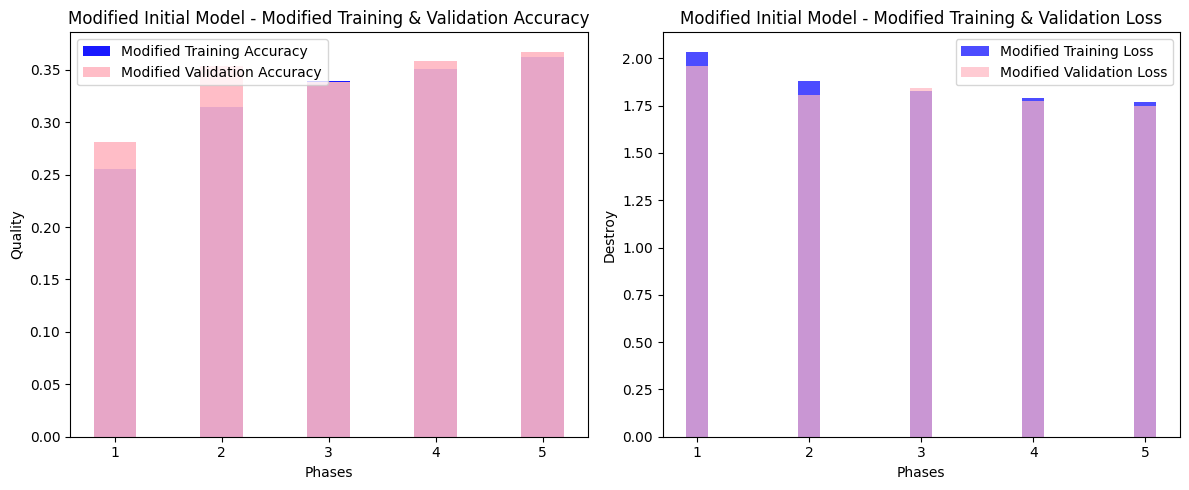

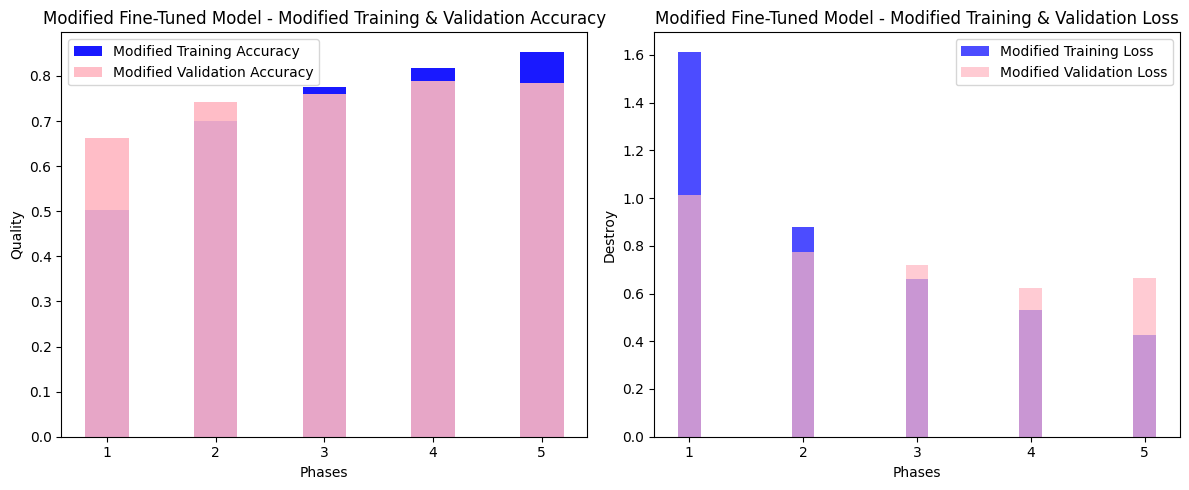

In [12]:
# Assuming modified_initial_history and modified_fine_tuned_history are defined
def plot_modified_training_history_bar(modified_history, custom_title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    epochs = range(1, len(modified_history.history['accuracy']) + 1)
    plt.bar(epochs, modified_history.history['accuracy'], label='Modified Training Accuracy', alpha=0.9,color='blue', width=0.4)
    plt.bar(epochs, modified_history.history['val_accuracy'], label='Modified Validation Accuracy', alpha=0.9,color='#ffb6c1', width=0.4)
    plt.xlabel('Phases')
    plt.ylabel('Quality')
    plt.title(f'{custom_title} - Modified Training & Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.bar(epochs, modified_history.history['loss'], label='Modified Training Loss', alpha=0.7,color='blue', width=0.2)
    plt.bar(epochs, modified_history.history['val_loss'], label='Modified Validation Loss', alpha=0.7,color='#ffb6c1', width=0.2)
    plt.xlabel('Phases')
    plt.ylabel('Destroy')
    plt.title(f'{custom_title} - Modified Training & Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_modified_training_history_bar(custom_model_history, 'Modified Initial Model')
plot_modified_training_history_bar(fine_tuned_custom_history, 'Modified Fine-Tuned Model')


313/313 [==============================] - 3s 9ms/step


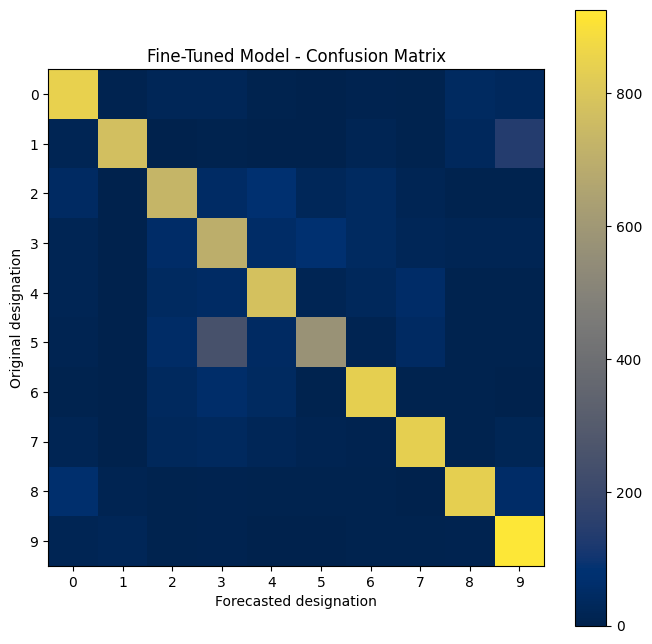

313/313 [==============================] - 4s 11ms/step


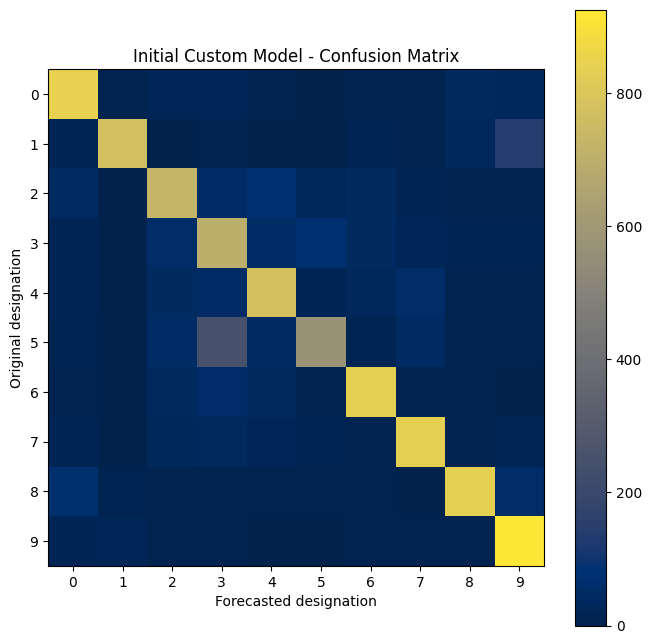

In [13]:
def plot_custom_confusion_matrix(custom_model, x, y_true, title):
    y_pred = custom_model.predict(x)
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.cividis)
    plt.title(f'{title} - Confusion Matrix')
    plt.colorbar()

    classes = range(10)
    plt.xticks(classes, classes)
    plt.yticks(classes, classes)

    plt.ylabel('Original designation')
    plt.xlabel('Forecasted designation')
    plt.show()

# Confusion matrix for both custom models
plot_custom_confusion_matrix(custom_model, x_test, y_test, 'Fine-Tuned Model')
plot_custom_confusion_matrix(custom_model, x_test, y_test, 'Initial Custom Model')
